In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sn
import pandas as pd
# import torchnet.meter.confusionmeter as cm

In [98]:
# Data augmentation and normalization for training
# Just normalization for validation & test
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [99]:
data_dir = '/home/tavakol/uni/ml4021/'

In [100]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [101]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [102]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [103]:
dataset_sizes, class_names

({'train': 244, 'val': 153}, ['ants', 'bees'])

In [104]:
#lists for graph generation
epoch_counter_train = []
epoch_counter_val = []
train_loss = []
val_loss = []
train_acc = []
val_acc = []

In [105]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [106]:
#Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch +1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            #For graph generation
            if phase == "train":
                train_loss.append(running_loss/dataset_sizes[phase])
                train_acc.append(running_corrects.double() / dataset_sizes[phase])
                epoch_counter_train.append(epoch)
            if phase == "val":
                val_loss.append(running_loss/ dataset_sizes[phase])
                val_acc.append(running_corrects.double() / dataset_sizes[phase])
                epoch_counter_val.append(epoch)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #for printing
            if phase == "train":
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == "val":
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [107]:
model_ft = models.resnet18(pretrained="imagenet")
for param in model_ft.parameters():
    param.requires_grad = False
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 256)
relu = nn.ReLU()
linear_layer2 = nn.Linear(256, 2)  # num_classes تعداد کلاس‌ها است

# اضافه کردن لایه‌های جدید به مدل
model_ft.add_module('relu', relu)
model_ft.add_module('linear_layer2', linear_layer2)

In [108]:
model_ft = model_ft.to(device)

In [109]:
criterion = nn.CrossEntropyLoss()

# Using Adam as the parameter optimizer
optimizer_ft = optim.Adam(model_ft.parameters(), lr = 0.001, betas=(0.9, 0.999))

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [110]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
----------


train Loss: 1.8002 Acc: 0.4713
val Loss: 0.6108 Acc: 0.7124

Epoch 2/25
----------
train Loss: 0.5736 Acc: 0.7172
val Loss: 0.4585 Acc: 0.8105

Epoch 3/25
----------
train Loss: 0.4590 Acc: 0.8197
val Loss: 0.3721 Acc: 0.8562

Epoch 4/25
----------
train Loss: 0.3709 Acc: 0.8566
val Loss: 0.3143 Acc: 0.8954

Epoch 5/25
----------
train Loss: 0.3146 Acc: 0.8770
val Loss: 0.3339 Acc: 0.8627

Epoch 6/25
----------
train Loss: 0.2843 Acc: 0.8893
val Loss: 0.2536 Acc: 0.9150

Epoch 7/25
----------
train Loss: 0.2793 Acc: 0.9139
val Loss: 0.2593 Acc: 0.9216

Epoch 8/25
----------
train Loss: 0.3080 Acc: 0.8811
val Loss: 0.2547 Acc: 0.9216

Epoch 9/25
----------
train Loss: 0.2703 Acc: 0.9098
val Loss: 0.2621 Acc: 0.8954

Epoch 10/25
----------
train Loss: 0.2890 Acc: 0.8975
val Loss: 0.2513 Acc: 0.9281

Epoch 11/25
----------
train Loss: 0.2554 Acc: 0.9303
val Loss: 0.2513 Acc: 0.9150

Epoch 12/25
----------
train Loss: 0.2769 Acc: 0.8770
val Loss: 0.2436 Acc: 0.9281

Epoch 13/25
----------


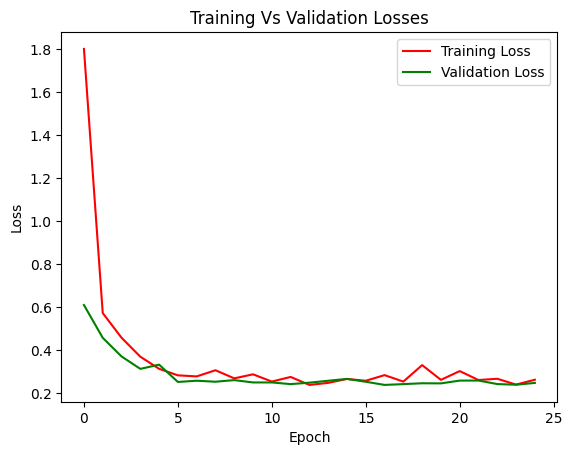

In [111]:
#Plot the train & validation losses
plt.figure(1)
plt.title("Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epoch_counter_train,train_loss,color = 'r', label="Training Loss")
plt.plot(epoch_counter_val,val_loss,color = 'g', label="Validation Loss")
plt.legend()
plt.show()

In [112]:
#Plot the accuracies in train & validation
plt.figure(2)
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epoch_counter_train, torch.tensor(train_acc).cpu().numpy(), color='r', label="Training Accuracy")
plt.plot(epoch_counter_val, torch.tensor(val_acc).cpu().numpy(), color='g', label="Validation Accuracy")
plt.legend()
plt.show()

In [113]:
#Test the accuracy with test data
correct = 0
total = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 92 %


In [114]:
#Class wise testing accuracy
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs, 1)
            point = (predicted == labels).squeeze()
            for j in range(len(labels)):
                label = labels[j]
                class_correct[label] += point[j].item()
                class_total[label] += 1

In [115]:
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))


Accuracy of  ants : 95 %
Accuracy of  bees : 90 %


In [116]:
from matplotlib.pyplot import imshow
from PIL import Image 
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)
    
    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        ax.imshow(img.squeeze(0).cpu().data[0])

        model.train(mode=was_training)

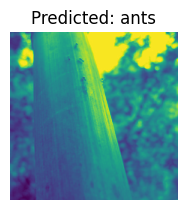

In [117]:
visualize_model_predictions(model_ft, "/home/tavakol/uni/ml4021/val/ants/8124241_36b290d372.jpg")

In [118]:
visualize_model_predictions(model_ft, "/home/tavakol/uni/ml4021/val/ants/205398178_c395c5e460.jpg")

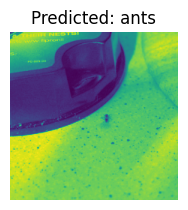

In [119]:
visualize_model_predictions(model_ft, "/home/tavakol/uni/ml4021/val/ants/172772109_d0a8e15fb0.jpg")

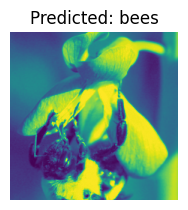

In [120]:
visualize_model_predictions(model_ft, "/home/tavakol/uni/ml4021/val/bees/151603988_2c6f7d14c7.jpg")

In [121]:
visualize_model_predictions(model_ft, "/home/tavakol/uni/ml4021/val/bees/144098310_a4176fd54d.jpg")

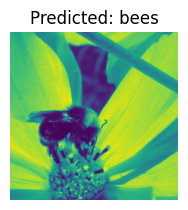

In [122]:
visualize_model_predictions(model_ft, "/home/tavakol/uni/ml4021/val/bees/224841383_d050f5f510.jpg")